# **Humayun Malik**   **(21I-2562)**
#Section : D
#Assignment 2




In [ ]:
import pandas as pd
import string
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
import numpy as np
import math
import random
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Load Data

In [ ]:

# Load the dataset from a URL
url = "https://github.com/google-research-datasets/xsum_hallucination_annotations/raw/master/factuality_annotations_xsum_summaries.csv"
df = pd.read_csv(url)


# Pre-Processing

In [ ]:
# Keep only the necessary columns: 'summary' and 'is_factual'
df = df[['summary', 'is_factual']]

# Remove duplicate summaries to avoid biased results
df = df.drop_duplicates(subset=['summary'])

# Convert the 'is_factual' column to binary labels
df['label'] = df['is_factual'].apply(lambda x: 1 if x == 'no' else 0)

# Preprocess the text data by converting to lowercase and removing non-alphabetic characters
df['summary'] = df['summary'].str.lower().str.replace('[^a-z\s]', '', regex=True)

# Display the first few rows of the dataset to verify preprocessing
print(df.head())

                                              summary is_factual  label
0   more than  pupils at a bristol academy have be...         no      1
3   the wife of a britishiranian woman jailed in i...         no      1
6   police searching for a greenock woman who has ...         no      1
9   aberdeen have appointed arbroath boss paul she...        yes      0
12  a sixyearold girl from cheshire who was given ...         no      1


# Bag Of Words Approach

In [ ]:


# Tokenize each summary and collect unique tokens to build a vocabulary
unique_tokens = set()
for summary in df['summary']:
    tokens = word_tokenize(summary)  # Tokenize the summary text
    unique_tokens.update(tokens)     # Add tokens to the set

# Display a sample of the unique tokens collected
print(f"Unique tokens (sample): {list(unique_tokens)[:20]}")

# Assign a unique index to each unique token (word-to-index mapping)
token_to_index = {token: idx for idx, token in enumerate(unique_tokens)}

# Initialize the Bag of Words (BoW) matrix with zeros
bow_matrix = np.zeros((df.shape[0], len(token_to_index)))

# Fill the BoW matrix with word counts for each summary
for i, summary in enumerate(df['summary']):
    tokens = word_tokenize(summary)  # Tokenize each summary
    for token in tokens:
        if token in token_to_index:  # Only consider tokens in the vocabulary
            bow_matrix[i, token_to_index[token]] += 1  # Increment count for each token

# Convert the matrix to a DataFrame for better readability
bow_df = pd.DataFrame(bow_matrix, columns=token_to_index.keys())


Unique tokens (sample): ['nebraska', 'reaction', 'al', 'yorkshires', 'shopping', 'calcutta', 'confederation', 'clyde', 'southgate', 'stevenages', 'standoff', 'statesays', 'truly', 'handset', 'jihadist', 'reports', 'auction', 'protecting', 'unveiled', 'londonderry']


# Regression Model

In [ ]:

# Prepare input data (X) as the Bag of Words matrix
X = bow_matrix

# Prepare the labels (Y) using the binary label column
Y = df['label'].values

# Split the data into training (80%) and testing sets (20%)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# Define the logistic regression class
class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=500):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        """Sigmoid function to map input to a probability."""
        return 1 / (1 + np.exp(-z))

    def fit(self, X_train, Y_train):
        """Train the logistic regression model."""
        num_features = X_train.shape[1]  # Number of features (tokens)
        self.weights = np.random.uniform(-0.1, 0.1, num_features)  # Initialize weights
        self.bias = 0  # Initialize bias

        # Train using gradient descent over the specified number of epochs
        for epoch in range(self.epochs):
            for i in range(len(X_train)):
                linear_output = np.dot(X_train[i], self.weights) + self.bias  # Compute linear combination
                prediction = self.sigmoid(linear_output)  # Apply sigmoid to get probability
                error = prediction - Y_train[i]  # Calculate the error

                # Update weights and bias using the gradient descent rule
                self.weights -= self.learning_rate * error * X_train[i]
                self.bias -= self.learning_rate * error

    def predict(self, X_test):
        """Make predictions using the trained model."""
        predictions = []
        for x in X_test:
            linear_output = np.dot(x, self.weights) + self.bias  # Compute linear output
            prob = self.sigmoid(linear_output)  # Apply sigmoid to get probability
            predictions.append(1 if prob >= 0.5 else 0)  # Classify based on the threshold 0.5
        return predictions

# Initialize and train the logistic regression model
log_reg = LogisticRegression(learning_rate=0.01, epochs=500)
log_reg.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = log_reg.predict(X_test)

# Evaluation

Accuracy: 0.9223
Precision: 0.9525
Recall: 0.9660
F1 Score: 0.9592
TP: 341, FP: 17
FN: 12, TN: 3


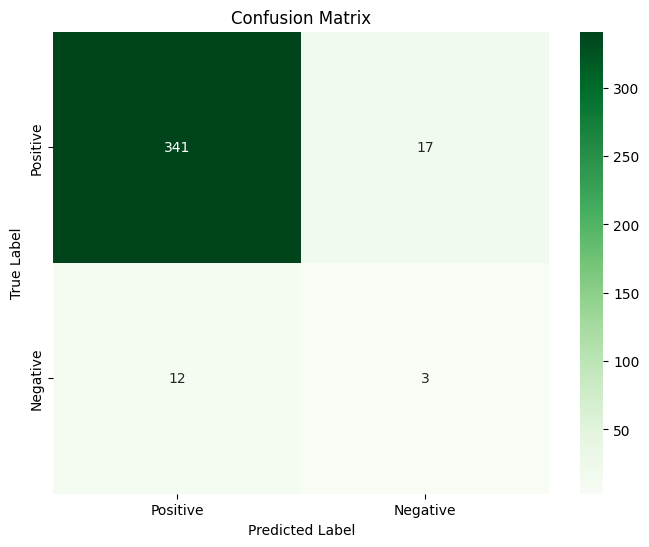

In [ ]:

# Calculate the confusion matrix (TP, TN, FP, FN)
TP = FP = TN = FN = 0
for true, pred in zip(Y_test, Y_pred):
    if true == 1 and pred == 1:
        TP += 1  # True Positive
    elif true == 0 and pred == 0:
        TN += 1  # True Negative
    elif true == 0 and pred == 1:
        FP += 1  # False Positive
    elif true == 1 and pred == 0:
        FN += 1  # False Negative

# Calculate evaluation metrics: accuracy, precision, recall, and F1 score
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print confusion matrix details
print(f"TP: {TP}, FP: {FP}")
print(f"FN: {FN}, TN: {TN}")

# Plot the confusion matrix using a heatmap
confusion_matrix = np.array([[TP, FP], [FN, TN]])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# K-Fold Validation


K-Fold Cross-Validation Results:
Fold 1 Accuracy: 0.8525
Fold 2 Accuracy: 0.8847
Fold 3 Accuracy: 0.8871
Fold 4 Accuracy: 0.8602
Fold 5 Accuracy: 0.8871

Average Accuracy: 0.8743
Standard Deviation of Accuracy: 0.0149


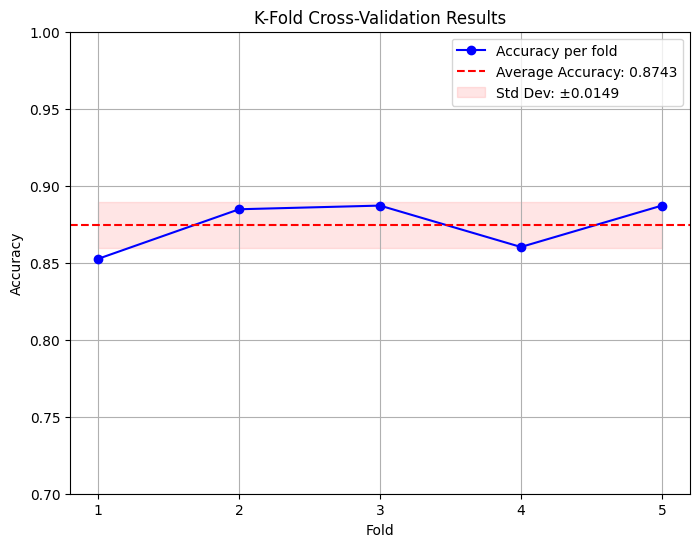

In [ ]:
# K-fold cross-validation implementation with plotting
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True)  # Initialize KFold with shuffling
accuracies = []  # List to store accuracies for each fold

# Print message for cross-validation results
print("K-Fold Cross-Validation Results:")

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    # Split data into training and testing sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Initialize the logistic regression model
    model = LogisticRegression(learning_rate=0.01, epochs=500)

    # Train the model on the current training set
    model.fit(X_train, Y_train)

    # Make predictions on the current test set
    Y_pred = model.predict(X_test)

    # Calculate accuracy for this fold
    TP = FP = TN = FN = 0  # Initialize confusion matrix values
    for true, pred in zip(Y_test, Y_pred):
        if true == 1 and pred == 1:
            TP += 1  # True Positive
        elif true == 0 and pred == 0:
            TN += 1  # True Negative
        elif true == 0 and pred == 1:
            FP += 1  # False Positive
        elif true == 1 and pred == 0:
            FN += 1  # False Negative

    # Compute accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)  # Store accuracy for this fold

    # Print accuracy for the current fold
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(accuracies)
std_deviation_accuracy = np.std(accuracies)

# Report the results
print(f"\nAverage Accuracy: {average_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_deviation_accuracy:.4f}")

# Plot the accuracies across folds
plt.figure(figsize=(8, 6))
plt.plot(range(1, k+1), accuracies, marker='o', linestyle='-', color='b', label='Accuracy per fold')
plt.axhline(average_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {average_accuracy:.4f}')
plt.fill_between(range(1, k+1),
                 average_accuracy - std_deviation_accuracy,
                 average_accuracy + std_deviation_accuracy,
                 color='r', alpha=0.1, label=f'Std Dev: ±{std_deviation_accuracy:.4f}')
plt.title('K-Fold Cross-Validation Results')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, k+1))
plt.ylim(0.7, 1)
plt.legend()
plt.grid(True)
plt.show()


# Error Analysis


In [ ]:
# Identify misclassified examples
misclassified_indices = [i for i in range(len(Y_test)) if Y_test[i] != Y_pred[i]]
misclassified_samples = X_test[misclassified_indices]

print("Misclassified examples:")
for i, index in enumerate(misclassified_indices):
    print(f"Example {i + 1}: {df['summary'].iloc[index]}")

Misclassified examples:
Example 1: a sixyearold girl from cheshire who was given a rare form of leukaemia by her parents has had a lifechanging trial in
Example 2: one in five parents in england eat vegetables at home a survey suggests
Example 3: police in southern china have seized more than   alcohol bottles and seized more than   bottles of contaminated milk local media report
Example 4: russias lower house of parliament has approved a bill that would allow russia to issue new passports to its citizens
Example 5: the confederation of african football  caf  and morocco have returned to the competition after a row in the confederation of african football broke down
Example 6: rory mcilroy will take a oneshot lead into the final round of the wgchsbc champions after carding a threeunder
Example 7: fortyeight people are feared dead after a passenger ferry caught fire off the coast of spain
Example 8: shale gas drilling in lancashire has been suspended after a magnitude  earthquake struck

# Analysis of Misclassifications in Hallucination Detection
## Overview
The misclassifications in the hallucination detection classifier reveal specific challenges in distinguishing factual statements from those containing hallucinations or speculative content.

###Common Patterns of Misclassification

*  **Ambiguity and Incomplete Information:** Sentences exhibit vague phrasing or missing context, leading to confusion in classification.
*   **Speculative Language:** Statements predicting future outcomes may appear factual but often contain elements of speculation that mislead the model.
* **Repetition and Redundancy:** Examples with redundant phrases complicate interpretation and may skew classification results.
* **Complex Sentence Structures:** Longer sentences or those with multiple clauses can obscure the main point leading to misclassification.
* **Contextual and Domain-Specific Challenges:** Some examples may contain jargon or nuances that confuse the model.

### Suggested Improvements
* **Data Quality Enhancement:** Clean the training dataset by removing incomplete sentences and reducing redundancy, ensuring clear and concise examples.
* **Feature Enrichment:** Incorporate additional linguistic features that capture verb tense, modality, and sentence structure to improve contextual understanding.
* **Diverse Training Data:** Broaden the dataset to encompass a wider range of topics and styles, helping the model learn to distinguish between factual and non-factual statements.
* **Focused Error Analysis:** Develop a structured error analysis process to categorize and understand misclassifications, allowing for targeted interventions.
* **Post-Processing Techniques:** Implement checks for ambiguity or contradictions in predicted classifications to improve reliability and accuracy.

## Conclusion
The analysis indicates that while the hallucination detection classifier demonstrates promise, refining data quality, enhancing feature extraction, and expanding the training dataset are crucial for improving its performance. Continuous evaluation and targeted improvements based on misclassification patterns will enhance the model's accuracy in distinguishing factual content from hallucinations.